In [91]:
import torch
import torchvision

from torchvision.datasets import ImageFolder, Flowers102
import datetime
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import MNIST, Flowers102, StanfordCars, CIFAR10
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import os
from torchvision.io import read_image
from torch.utils.data import Dataset, dataset
import pandas as pd
import numpy as np
from datetime import datetime
import pytorch_lightning as pl
import cv2
pl.seed_everything(0)

Seed set to 0


0

In [92]:
img_start_size = 64 # 64
img_pred_size = 128 # 256
n_T = 1000
n_T_start = 1000 #150
batch_size = 32 # 16
device = "cuda"
n_feat = 128
l_rate = 0.00006
save_model = False
save_dir = './imgs/'

In [93]:
resize_org = torchvision.transforms.Compose([transforms.RandomHorizontalFlip(), transforms.Resize((img_pred_size, img_pred_size)),
                                               transforms.ToTensor()])
to_pil = torchvision.transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])
resize_low = torchvision.transforms.Compose([transforms.ToPILImage(), transforms.Resize((img_start_size, img_start_size)),
                                              transforms.ToTensor()])
resize_high = torchvision.transforms.Compose([transforms.ToPILImage(), transforms.Resize((img_pred_size, img_pred_size),
                                                                                                                  torchvision.transforms.InterpolationMode.BOX),
                                               transforms.ToTensor()])
resize_high_BILINEAR = torchvision.transforms.Compose([transforms.ToPILImage(), transforms.Resize((img_pred_size, img_pred_size),
                                                                                                                  torchvision.transforms.InterpolationMode.BILINEAR),
                                               transforms.ToTensor()])

In [94]:
# TRAIN
dataset = ImageFolder('/home/maxim/Downloads/archive (2)/img_align_celeba/', resize_org)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=20)

# VAL
dataset = ImageFolder('/home/maxim/Downloads/archive (2)/val2/', resize_org)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=20)

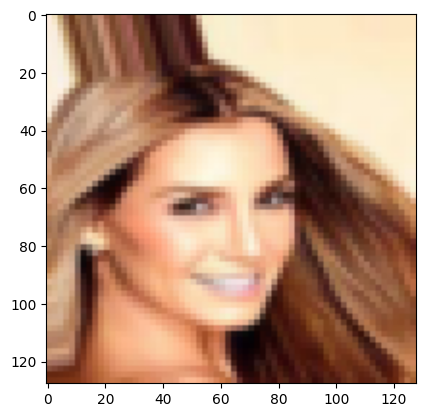

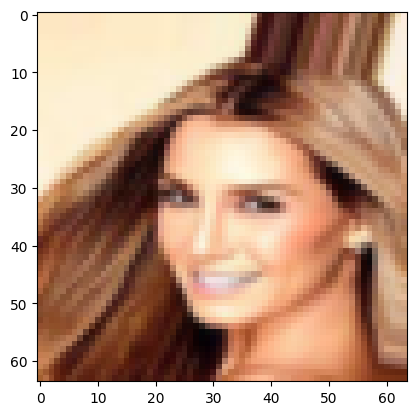

In [95]:
plt.imshow(resize_high(resize_low(train_loader.dataset[0][0])).permute(1,2,0))
plt.show()
plt.imshow(resize_low(train_loader.dataset[0][0]).permute(1,2,0))
plt.show()

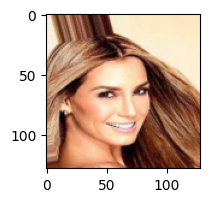

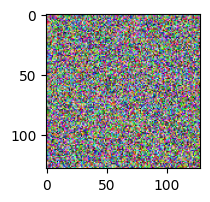

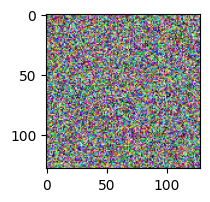

In [96]:
plt.figure(1, [2,2])

plt.imshow(train_loader.dataset[0][0].permute(1,2,0))
plt.show()

plt.figure(1, [2,2])

plt.imshow(torch.rand_like(train_loader.dataset[0][0].permute(1,2,0)))
plt.show()

plt.figure(1, [2,2])

plt.imshow(torch.rand_like(train_loader.dataset[0][0].permute(1,2,0)) * n_T_start/n_T +
            resize_high(resize_low(train_loader.dataset[0][0])).permute(1,2,0) * (1 - (n_T_start/n_T)))
plt.show()

In [97]:
class ResidualConvBlock(nn.Module):
    """
    A residual convolutional block with two convolutinal layers and GELU activation.
    """
    def __init__(
        self, in_channels, out_channels, is_res = False
    ) -> None:
        super().__init__()
        # Check if input and output channels are same for resiual connectoin
        self.same_channels = in_channels==out_channels
        # Whether to perform residual connection
        self.is_res = is_res

        # First convolutoinal layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

        # Second convolutoinal layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x):
        if self.is_res:
            # Residual
            x1 = self.conv1(x)
            # Second conv layer
            x2 = self.conv2(x1)

            # Add residual connection based on channels
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2

            return out
        else:
            # Non-residual
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

In [98]:
class UnetDown(nn.Module):
    """
    A downscampling block for my cnn model.
    """
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()

        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [99]:
class UnetUp(nn.Module):
    """
    An upsampling block for my cnn model.
    """
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()

        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        # Concatenate the input with the skip connection of resnet
        x = torch.cat((x, skip), 1)

        # Run the concatanated tensor throgh the model
        x = self.model(x)

        return x

In [100]:
class EmbedFC(nn.Module):
    """
    A network for embedding features.
    """
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()

        self.input_dim = input_dim

        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Reshape the input tensor to a single dimensoin
        x = x.view(-1, self.input_dim)

        # pass the input through the embeding network
        return self.model(x)

In [101]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat = 128):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat

        # Initial conv
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        # Downsampling blocks
        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)
        self.down3 = UnetDown(2 * n_feat, 4 * n_feat)

        # Feacter vect extract for context and time embeddings
        self.to_vec = nn.Sequential(nn.AvgPool2d(4), nn.GELU())

        # Embeddings for context and time info
        self.timeembed1 = EmbedFC(1, 4*n_feat)
        self.timeembed2 = EmbedFC(1, 2*n_feat)
        self.timeembed3 = EmbedFC(1, 1*n_feat)
        # self.contextembed1 = EmbedFC(_n_classes, 4*n_feat)
        # self.contextembed2 = EmbedFC(_n_classes, 2*n_feat)
        # self.contextembed3 = EmbedFC(_n_classes, 1*n_feat)

        # Upscaling blocks
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(4 * n_feat, 4 * n_feat, 4, 4),
            nn.GroupNorm(4, 4 * n_feat),
            nn.GELU(),
        )

        self.up1 = UnetUp(8 * n_feat, n_feat * 2)
        self.up2 = UnetUp(4 * n_feat, n_feat)
        self.up3 = UnetUp(2 * n_feat, n_feat)

        # Output conv
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.GELU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, c, t, context_mask):
        x = self.init_conv(x)

        # Downsampling
        down1 = self.down1(x)
        down2 = self.down2(down1)
        down3 = self.down3(down2)

        # Feature vector for context and time embedding
        hiddenvec = self.to_vec(down3)

        # Convert context information to one-hot encoding and apply context mask
        # c = nn.functional.one_hot(c, num_classes=self.n_classes).type(torch.float)

        # c_new = torch.zeros(c.shape[0])
        # i = 0
        # for cont in c:
        #     c_new[i] = cont[1]
        #     i += 1

        # cemb1 = self.contextembed1(c).view(-1, self.n_feat * 4, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 4, 1, 1)
        # cemb2 = self.contextembed2(c).view(-1, self.n_feat * 2, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat * 2, 1, 1)
        # cemb3 = self.contextembed3(c).view(-1, self.n_feat, 1, 1)
        temb3 = self.timeembed3(t).view(-1, self.n_feat, 1, 1)

        # Upsampling path with context and time embeddings
        up1 = self.up0(hiddenvec)
        # up2 = self.up1(cemb1*up1+ temb1, down3)
        # up3 = self.up2(cemb2*up2+ temb2, down2)
        # up4 = self.up3(cemb3*up3+ temb3, down1)
        up2 = self.up1(up1+ temb1, down3)
        up3 = self.up2(up2+ temb2, down2)
        up4 = self.up3(up3+ temb3, down1)
        out = self.out(torch.cat((up4, x), 1))

        return out

In [102]:
def ddpm_schedules(beta1, beta2, T):
    """
    This function computes and returns pre-computed schedules for DDPM sampling and training.
    """

    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    # Compute values for noise
    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()
    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)
    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab
    
    return {
        "alpha_t": alpha_t,
        "oneover_sqrta": oneover_sqrta,
        "sqrt_beta_t": sqrt_beta_t,
        "alphabar_t": alphabar_t,
        "sqrtab": sqrtab,
        "sqrtmab": sqrtmab,
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,
    }


In [103]:
tf = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

In [104]:
def cvtImg(img, channels=3):
    if channels == 4:
        imgs = img
        i = 0
        for image in img:
            image = image - image.min()
            image = (image / image.max())
            imgs[i] = tf(image.numpy().astype(float)).permute(1,2,0)
            i += 1
        return imgs
    
    img = img - img.min()
    image = (img / img.max())
    return tf(img.numpy().astype(float))

In [105]:
class DDPM(pl.LightningModule):
    def __init__(self, nn_model=ContextUnet(in_channels=3, n_feat=n_feat),
                 betas=(1e-4, 0.02), n_T=n_T, device=device, timesteps=n_T,
                 device_=device, drop_prob=0.1, learning_rate=1e-4):
        super(DDPM, self).__init__()

        # Initialize the neural network model
        self.nn_model = nn_model.to(device_)

        # Register pre-computed schedules for diffusion process (noise gen)
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.learning_rate = learning_rate
        self.step = 0
        self.n_T = timesteps
        self.drop_prob = drop_prob
        self.loss_mse = nn.SmoothL1Loss()
        self.avg_loss = 0
        self.step_ = 1

    def forward(self, x, c):
        # Sample a random diffusion timestep
        _ts = torch.randint(1, self.n_T+1, (x.shape[0],)).to(self.device)

        # Generate noise for diffusion process
        noise = torch.randn_like(x)

        # Compute the denoised image at the chosen timestep
        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * noise
        )

        # Apply context mask with dropout
        context_mask = torch.bernoulli(torch.zeros_like(c, dtype=torch.float) + self.drop_prob).to(self.device)

        # Compute the loss between the prediced noise and the actual noise
        return self.loss_mse(noise, self.nn_model(x_t, c, _ts / self.n_T, context_mask))
    
    def sampleSuperRes(self, n_sample, size, x, device, img_mode = 'BOX', guide_w = 1.0):
        if img_mode == 'BOX':
            x_i = torch.randn(n_sample, *size).to(device) * n_T_start/n_T + resize_high(resize_low(x[0])).to(device) * (1 - (n_T_start/n_T))
        if img_mode == 'BILINEAR':
            x_i = torch.randn(n_sample, *size).to(device) * n_T_start/n_T + resize_high_BILINEAR(resize_low(x[0])).to(device) * (1 - (n_T_start/n_T))

        #torch.rand_like(data.dataset[0][0].permute(1,2,0))  +
        #    resize_high(resize_low(data.dataset[0][0])).permute(1,2,0) * (1 - (n_T_start/n_T))

        c_i = torch.arange(0,1).to(device) # context for us just cycles throught the mnist labels
        c_i = c_i.repeat(int(n_sample/c_i.shape[0]))

        # don't drop context at test time
        context_mask = torch.zeros_like(c_i).to(device)

        # double the batch
        c_i = c_i.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 1. # makes second half of batch context free

        x_i_store = [] # keep track of generated steps in case want to plot something 
        print()

        for i in range(n_T_start, 0, -1):
            t_is = torch.tensor([i / self.n_T]).to(device)
            t_is = t_is.repeat(n_sample,1,1,1)

            # double batch
            x_i = x_i.repeat(2,1,1,1)
            t_is = t_is.repeat(2,1,1,1)

            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0

            # split predictions and compute weighting
            eps = self.nn_model(x_i, c_i, t_is, context_mask)
            eps1 = eps[:n_sample]
            eps2 = eps[n_sample:]
            eps = (1+guide_w)*eps1 - guide_w*eps2
            x_i = x_i[:n_sample]
            x_i = (
                self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )
            if i%20==0 or i==self.n_T or i<8:
                x_i_store.append(x_i.detach().cpu().numpy())

        x_i_store = np.array(x_i_store)
        return cvtImg(x_i.detach().cpu(), 4), x_i_store
    
    def sampleInpaint(self, n_sample, size, x, device, guide_w = 1.0):
        transform_norm = transforms.Compose([
            transforms.Normalize(0, 1)
        ])
        x_img_org = x

        x_i = transform_norm(torch.randn(n_sample, *size).to(device))

        c_i = torch.arange(0,1).to(device) # context for us just cycles throught the mnist labels
        c_i = c_i.repeat(int(n_sample/c_i.shape[0]))

        # don't drop context at test time
        context_mask = torch.zeros_like(c_i).to(device)

        # double the batch
        c_i = c_i.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 1. # makes second half of batch context free

        x_i_store = [] # keep track of generated steps in case want to plot something 
        print()

        org_img_non_masked = torch.split(x_img_org[0].repeat(2,1,1,1), 64, 3)[0]

        for i in range(n_T, 0, -1):
            t_is = torch.tensor([i / self.n_T]).to(device)
            t_is = t_is.repeat(n_sample,1,1,1)

            # double batch
            x_i = x_i.repeat(2,1,1,1)
            t_is = t_is.repeat(2,1,1,1)

            if i == n_T_start:
                img = torch.cat([org_img_non_masked, torch.split(x_i, 64, 3)[1]], 3)
            else:
                img = torch.cat([torch.split(img, 64, 3)[1], torch.split(x_i, 64, 3)[1]], 3)

            print("Max-orig: " + org_img_non_masked.max().__str__())
            print("Max-noise: " + torch.split(x_i, 64, 3)[1].max().__str__())

            grid = make_grid(img, nrow=10)
            save_image(grid, save_dir + f"temp.png")
            
            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0

            # split predictions and compute weighting
            eps = self.nn_model(img, c_i, t_is, context_mask)

            if i == 0:
                img = torch.cat([org_img_non_masked, torch.split(x_i, 64, 3)[1]], 3)

            eps1 = eps[:n_sample]
            eps2 = eps[n_sample:]
            eps = (1+guide_w)*eps1 - guide_w*eps2
            x_i = x_i[:n_sample]
            x_i = (
                self.oneover_sqrta[i] * (x_i - self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            ) * 0.993
            if i%20==0 or i==self.n_T or i<8:
                x_i_store.append(x_i.detach().cpu().numpy())

        x_i_store = np.array(x_i_store)
        return cvtImg(img.detach().cpu(), 4), x_i_store
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), self.learning_rate)
    
    def val_dataloader(self):
        return val_loader
    
    def training_step(self, batch, batch_idx):
        x, c = batch
        loss_ema = None
        
        loss = self(x, c)

        if loss_ema is None:
            loss_ema = loss.item()
        else:
            loss_ema = 0.95 * loss_ema + 0.05 * loss.item()

        self.step += 1
        self.step_+= 1
        self.avg_loss += loss

        self.log("loss", loss, on_step=True, prog_bar=True)

        return {'loss': loss}

    def validation_step(self, batch):
        x, c = batch

        n_sample = 1
        x_gen, x_gen_store = self.sampleInpaint(n_sample, (3, img_pred_size, img_pred_size), x, device, guide_w=0.0)
        # x_gen, x_gen_store = self.sampleSuperRes(n_sample, (3, img_pred_size, img_pred_size), x, device, guide_w=0.0)

        x_gen = torch.concat((x_gen, torch.unsqueeze(resize_high(resize_low(x[0])).detach().cpu(), 0), torch.unsqueeze(x[0].detach().cpu(), 0)))
        # x_gen = torch.concat((x_gen, x_gen1, torch.unsqueeze(resize_high(resize_low(x[0])).detach().cpu(), 0), torch.unsqueeze(x[0].detach().cpu(), 0)))


        print("Max-x_gen: " + x_gen.max().__str__())
        print("Min-x_gen: " + x_gen.min().__str__())

        grid = make_grid(x_gen, nrow=10)
        save_image(grid, save_dir + f"image_{self.step}.png")
        #print('saved image at ' + save_dir + f"image_{self.step}.png")
        print("AVG LOSS: " + (self.avg_loss / self.step_).__str__())

    def on_train_epoch_end(self):        
        dict = self.state_dict()

        dict["pytorch-lightning_version"] = '2.1.0'
        dict["global_step"] = self.step
        dict["epoch"] = self.current_epoch
        print(self.current_epoch)
        dict["state_dict"] = self.state_dict()

        now = datetime.now()

        dt_string = now.strftime("%Y|%m|%d %H:%M:%S")
        
        torch.save(dict, "saves/diffusion_model" + "|time: " + dt_string + "|step: " + self.step.__str__() + ".ckpt")

In [106]:
torch.set_float32_matmul_precision('medium')

In [107]:
ddpm = DDPM(nn_model=ContextUnet(in_channels=3, n_feat=n_feat),
             betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1, learning_rate=l_rate)

trainer = pl.Trainer(accelerator=device, max_epochs=10000, precision='16-mixed')

ddpm = DDPM.load_from_checkpoint('saves/diffusion_model|time: 2024|01|23 13:49:45|step: 12500.ckpt')

trainer.fit(ddpm, train_dataloaders=train_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type         | Params
------------------------------------------
0 | nn_model | ContextUnet  | 14.7 M
1 | loss_mse | SmoothL1Loss | 0     
------------------------------------------
14.7 M    Trainable params
0         Non-trainable params
14.7 M    Total params
58.818    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]


Max-orig: tensor(1., device='cuda:0')
Max-noise: tensor(3.9942, device='cuda:0')
Max-orig: tensor(1., device='cuda:0')
Max-noise: tensor(3.7831, device='cuda:0')
Max-orig: tensor(1., device='cuda:0')
Max-noise: tensor(3.9891, device='cuda:0')
Max-orig: tensor(1., device='cuda:0')
Max-noise: tensor(4.0348, device='cuda:0')
Max-orig: tensor(1., device='cuda:0')
Max-noise: tensor(4.0953, device='cuda:0')
Max-orig: tensor(1., device='cuda:0')
Max-noise: tensor(4.1285, device='cuda:0')
Max-orig: tensor(1., device='cuda:0')
Max-noise: tensor(4.1763, device='cuda:0')
Max-orig: tensor(1., device='cuda:0')
Max-noise: tensor(4.3444, device='cuda:0')
Max-orig: tensor(1., device='cuda:0')
Max-noise: tensor(4.2368, device='cuda:0')
Max-orig: tensor(1., device='cuda:0')
Max-noise: tensor(4.0572, device='cuda:0')
Max-orig: tensor(1., device='cuda:0')
Max-noise: tensor(4.0934, device='cuda:0')
Max-orig: tensor(1., device='cuda:0')
Max-noise: tensor(4.3537, device='cuda:0')
Max-orig: tensor(1., device

In [ ]:
trainer.validate(ddpm, dataloaders=val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]


AVG LOSS: tensor(0.0031, device='cuda:0')


[{}]

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/